In [ ]:
def kalman_mean(y):

    Vw = 1e-4/(1- 1e-4)
    Ve = 1e-4

    R = 0
    m = np.zeros(len(y))
    Q = np.zeros(len(y))

    for t in range(1,len(y)):
        m[t] = m[t-1]
        R = R + Vw

        yhat = m[t]
        Q[t]= R + Ve
        e = y[t] - yhat

        K=R/Q[t]
        m[t] = m[t] + K*e

        R = R - K*R
    
    return m, Q

def ret_metrics(daily_ret_df):
    start_date, end_date = daily_ret_df.index[[0,-1]]
    years = (end_date - start_date).days/365
    
    daily_ret_df[daily_ret_df <-1] = -1
    
    #CGR
    CGR = (1 + daily_ret_df).cumprod() - 1
    CAGR = (CGR[-1] + 1)**(1/years) - 1

    #Information Ratios
    sharpe = daily_ret_df.mean()/daily_ret_df.std()
    if np.isnan(sharpe):
        sharpe = 0
    #rolling_sharpe = daily_ret_df.rolling(window=126).mean()/daily_ret_df.rolling(window=126).std()

    #Drawdown
    roll_max = (1+CGR).cummax()
    drawdown = (1+CGR)/roll_max - 1.0
    max_drawdown= drawdown.min()
    drawdown_times = (drawdown < 0).astype(np.int64)
    max_drawdown_duration = drawdown_times.groupby((drawdown_times != drawdown_times.shift()).cumsum()).cumsum().min()
    
    #Win/Loss percentage
    winners = (daily_ret_df > 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    losers = (daily_ret_df < 0).sum() / ((daily_ret_df > 0).sum() + (daily_ret_df < 0).sum())
    
    print(f'CAGR: {np.round(100*CAGR,2)}% \
          \nAnnual Sharpe Ratio: {round(252**0.5 * sharpe,2)} \
          \nWin Percetage: {np.round(100*winners, 2)}% \
          \nLoss Percetage: {np.round(100*losers, 2)}% \
          \nMax win: {np.round(100*daily_ret_df.max(),2)}% \
          \nMax Loss: {np.round(100*daily_ret_df.min(),2)}% \
          \nAverage Win/Loss: {np.round(100*daily_ret_df.mean(), 2)}% \
          \nMax Drawdown: {np.round(100*max_drawdown,2)}% \
          \nMax Drawdown Duration: {max_drawdown_duration} \
          \n\n')
    
    CGR.plot()
    plt.title('Cummulative Growth')
    plt.show()
    
    drawdown.plot()
    plt.title('Drawdown')
    plt.show()
    #return drawdown

In [ ]:
column_names = {
    'Highprice': 'High',
    'Lowprice': 'Low',
    'Closingprice': 'Close',
    'Averageprice': 'Average',
    'Totalvolume' : 'Volume',
}

warrant_long = pd.read_csv('_SSE223976_2021-10-27.csv', sep=';',header=1).iloc[:,:-1]
warrant_long = warrant_long.rename(columns=column_names).sort_values('Date')
warrant_long.index = pd.to_datetime(warrant_long.set_index('Date').index)

warrant_short = pd.read_csv('_SSE222633_2021-10-27.csv', sep=';',header=1).iloc[:,:-1]
warrant_short = warrant_short.rename(columns=column_names).sort_values('Date')
warrant_short.index = pd.to_datetime(warrant_short.set_index('Date').index)

full_df = pd.concat({
    'W_long': warrant_long['Close'],
    'W_short': warrant_short['Close'],
    'OMX30': omx30['Close']
    }, axis=1)

warrants = full_df[['W_long', 'W_short']]

In [ ]:
omx30 = yf.Ticker("^OMX").history(start='2010-05-01')

In [ ]:
#Z_score mean reversion
transaction_percentage = 0.01
lookback = 252
z_entry = 0.8
z_exit = 0

omx_ret = omx30['Close'].pct_change()
m, Q = kalman_mean(omx_ret)
omx_ret_rm = m# omx_ret.rolling(window=lookback).mean()
omx_ret_std = np.sqrt(Q)#omx_ret.rolling(window=lookback).std()
z_score = (omx_ret - omx_ret_rm)/omx_ret_std

weights = pd.Series(np.zeros(len(omx_ret)), index=omx_ret.index)

long_entry = z_score < -z_entry
long_exit = z_score >= -z_exit
short_entry = z_score > z_entry
short_exit = z_score <= z_exit

num_units_long = np.nan*np.zeros(len(omx_ret))
num_units_short = np.nan*np.zeros(len(omx_ret))

num_units_long[0] = 0
num_units_long[long_entry] = 1
num_units_long[long_exit] = 0
num_units_long = pd.DataFrame(num_units_long).fillna(method="ffill").values.T

num_units_short[0] = 0
num_units_short[short_entry] = -1
num_units_short[short_exit] = 0
num_units_short = pd.DataFrame(num_units_short).fillna(method="ffill").values.T

weights = pd.Series((num_units_long + num_units_short).reshape(-1), index = omx_ret.index)

k = 5 # Leverage of Product
transaction_cost = transaction_percentage*(abs(weights.diff())) #Cost of buying product
hold_cost = (0.03/100)*(abs(weights.shift(1))) #Cost of holding product
rets = k*(weights.shift(1)*omx_ret).fillna(0) - transaction_cost - hold_cost

ret_metrics(rets)

In [ ]:
# Market Mean Reversion Strategy
transaction_percentage = 0.01

omx_ret = omx30['Close'].pct_change()
omx_ret_mean = m
omx_ret_std = np.sqrt(Q)

excess = omx_ret - omx_ret_mean
weights = - np.sign(excess)
weights[abs(excess) <= 0.05/100] = 0

k = 10 # Leverage of Product
transaction_cost = transaction_percentage*(abs(weights.diff())) #Cost of buying product
hold_cost = (0.03/100)*(abs(weights.shift(1) - weights.shift(1).diff())) #Cost of holding product
rets = k*weights.shift(1)*omx_ret# - transaction_cost - hold_cost

ret_metrics(rets)

In [ ]:
#Try momentum strategy
close = omx30['Close']
train_close = close[:train_split]
test_close = close[train_split:]
omx_ret = close.pct_change()
train_split = int(0.6*close.shape[0])

lookback = [1, 5, 10, 25, 60, 120, 250]
holddays = [1, 5, 10, 25, 60, 120, 250]

results = pd.DataFrame([])
for lb in lookback:
    for hd in holddays:
        ret_lag = train_close.pct_change(lb)
        ret_fut = (train_close.shift(-hd) - train_close[:train_split])/train_close[:train_split]
        bad_dates = ret_lag.isna() | ret_fut.isna()
        
        ret_lag = ret_lag[~bad_dates]
        ret_fut = ret_fut[~bad_dates]
        
        if lb >= hd:
            jump = lb
        else:
            jump = hd
        
        fut = ret_fut
        lag = ret_lag
        ret_lag = ret_lag[:len(ret_lag):jump]
        ret_fut = ret_fut[:len(ret_fut):jump]
        cc, p_val =corr(ret_lag, ret_fut)
        
        results = results.append(pd.DataFrame([[lb, hd, cc, p_val]], columns=['lookback', 'holddays','cc', 'p_val']), ignore_index=True)
#results.sort_values(['lookback', 'holddays'])

In [ ]:
lookback, holddays = (100,10)
test_ret = test_close.pct_change()

longs = test_close > test_close.shift(lookback)
shorts = test_close < test_close.shift(lookback)

pos = pd.Series(np.zeros(test_close.shape), index=test_close.index)
for h in range(holddays):
    long_lag = longs.shift(h)
    long_lag[long_lag.isna()] = False
    #long_lag = long_lag*1
    
    short_lag = shorts.shift(h)
    short_lag[short_lag.isna()] = False
    #short_lag = short_lag*1
    
    pos[long_lag] = pos[long_lag] + 1
    pos[short_lag] = pos[short_lag] - 1
    
k = 10
transaction_cost = 0.01*(abs(pos.diff())) #Cost of buying product
hold_cost = (0.03/100)*(abs(pos.shift(1) - pos.shift(1).diff())) #Cost of holding product
rets = k*(pos.shift(1)*test_ret) #- transaction_cost - hold_cost

ret_metrics(rets)

In [ ]:
lookback=250

tick = yf.Ticker('TSLA').history(start='2015-05-01')
close = tick['Close']

ret = close.pct_change()
m, Q = kalman_mean(ret)

ret_rm = m#ret.rolling(window=lookback).mean()
ret_std = np.sqrt(Q)#ret.rolling(window=lookback).std()
z_score = (ret - ret_rm)/ret_std

weights = pd.Series(np.zeros(len(omx_ret)), index=omx_ret.index)

z_entry = 0.75
z_exit = -1

long_entry = z_score < -z_entry
long_exit = z_score >= -z_exit
short_entry = z_score > z_entry
short_exit = z_score <= z_exit

num_units_long = np.nan*np.zeros(len(ret))
num_units_short = np.nan*np.zeros(len(ret))

num_units_long[0] = 0
num_units_long[long_entry] = 1
num_units_long[long_exit] = 0
num_units_long = pd.DataFrame(num_units_long).fillna(method="ffill").values.T

num_units_short[0] = 0
num_units_short[short_entry] = -1
num_units_short[short_exit] = 0
num_units_short = pd.DataFrame(num_units_short).fillna(method="ffill").values.T

weights = pd.Series((num_units_long + num_units_short).reshape(-1), index = ret.index)

k = 1 # Leverage of Product
transaction_cost = transaction_percentage*(abs(weights.diff())) #Cost of buying product
hold_cost = (0.03/100)*(abs(weights.shift(1))) #Cost of holding product
rets = k*(weights.shift(1)*ret).fillna(0) #- transaction_cost - hold_cost

ret_metrics(rets)
ret_metrics(ret)

In [854]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR

#^GDAXI ^N225 ^DJI
ticks = yf.Tickers("^OMX ATCO-A.ST").history(start="2011-05-01")
close = ticks['Close'].fillna(method="ffill")
opens = ticks['Open'].fillna(method = 'ffill')
mid = (ticks['Close'].fillna(method="ffill") + ticks['Open'].fillna(method="ffill"))/2

[*********************100%***********************]  2 of 2 completed


In [852]:
window_size = 300

yF = pd.DataFrame()
for t in range(window_size,len(mid)):
    model = VAR(mid[t-window_size:t].values)
    fit = model.fit(1)
    forecast = fit.forecast([mid.iloc[t-1]], steps=1)
    yF = yF.append(pd.DataFrame(forecast, columns=mid.columns, index=[mid.index[t]]))

CAGR: 1.79%           
Annual Sharpe Ratio: 0.27           
Win Percetage: 50.99%           
Loss Percetage: 49.01%           
Max win: 4.21%           
Max Loss: -5.29%           
Average Win/Loss: 0.01%           
Max Drawdown: -17.44%           
Max Drawdown Duration: 0           




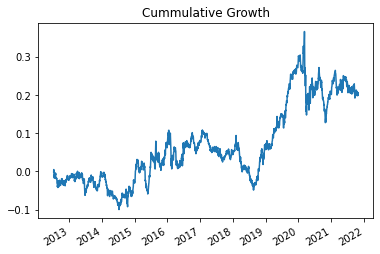

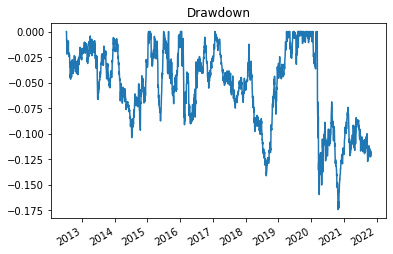

In [855]:
retF = (yF-opens).div(opens, axis=1)[window_size:]
mean = retF.mean(axis=1)

weights = retF.add(-mean, axis=0)
weights = weights.div(abs(weights).sum(axis=1), axis=0)

K = 1
rets = K*weights.shift(1)*close.pct_change() #- (1/100)*abs(weights.diff()) - (0.03/100)

#rets = rets.sum(axis=1) 

ret_metrics(rets['^OMX'])

In [887]:
mini_L = pd.read_csv('./Backtest Engine/omx30mini_L_2020_12_01-2021-10-30.csv', sep=';',header=1).iloc[:,:-1].rename(columns={'Datum': 'Date', 'Stängn.kurs': 'Long'}).set_index('Date')['Long']
mini_S = pd.read_csv('./Backtest Engine/omx30mini_S_2021_02_01-2021_10_30.csv', sep=';',header=1).iloc[:,:-1].rename(columns={'Datum': 'Date', 'Stängn.kurs': 'Short'}).set_index('Date')['Short']

full = pd.DataFrame([])

full = full.append(mini_L)
full = full.append(mini_S)

full = full.T

pd.read_csv('./omx_minif_LS_2021-02-01_2021-10_29.csv', index_col=0)

,Long,Short
2021-02-01,"200,44","575,98"
2021-02-02,"217,62","575,98"
2021-02-03,"229,21","575,98"
2021-02-04,"235,62","575,98"
2021-02-05,"216,73","575,98"
...,...,...
2021-10-25,"550,70","109,94"
2021-10-26,"559,85","99,29"
2021-10-27,"549,97","115,12"
2021-10-28,"531,95","125,31"


In [929]:
model = ARIMA(close['^OMX'].iloc[-300:].values, order=(1,0,0))
fit = model.fit()
fit.forecast()[0]

array([2290.02432222])

In [928]:
close['^OMX'].iloc[-300:].values[-3:]

array([2323.16992188, 2313.23999023, 2290.85009766])